In [1]:
#import processing
from PIL import Image
import os
import pandas as pd
import numpy as np
import skgstat as skg
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import itertools

In [2]:
'''
TODO:
1. Standardize file formats?
2. Denormalize elevation (for mean/var and vario)
3. Standardize color bar limits for comparing mean/var

'''

'\nTODO:\n1. Standardize file formats?\n2. Denormalize elevation (for mean/var and vario)\n3. Standardize color bar limits for comparing mean/var\n\n'

In [3]:
sgsdir = "SGS_training_sample/parquet"
dcgandir = "DCGAN/generated_images_256"
diffusiondir = "256_sim_cp_10.csv"


coord = pd.read_csv("coords_256.csv").values

In [4]:
#SGS - 50 realizations
sgs = np.empty((len(os.listdir(sgsdir)), 256, 256))

for i, name in enumerate(os.listdir(sgsdir)):
    sgs[i] = pd.read_parquet(sgsdir+"/"+name).values.reshape(300,300)[:256, :256]

In [5]:
sgs = (sgs + 1)/2

In [6]:
def plot_colormap(X, Y, Color, colorbar_title, title):

    fig = plt.figure(figsize = (6,5))
    ax = plt.gca()
    im = ax.scatter(X, Y, c=Color, marker='.', s=5, cmap='gist_earth')
    plt.title(title)
    plt.xlabel('X [m]'); plt.ylabel('Y [m]')
    plt.locator_params(nbins=5)
    plt.axis('scaled')

    # make colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(im, ticks=np.linspace(np.min(Color), np.max(Color), 11), cax=cax)
    cbar.set_label(colorbar_title, rotation=270, labelpad=15)
    fig.savefig("Plots/"+title+".png", dpi = fig.dpi)

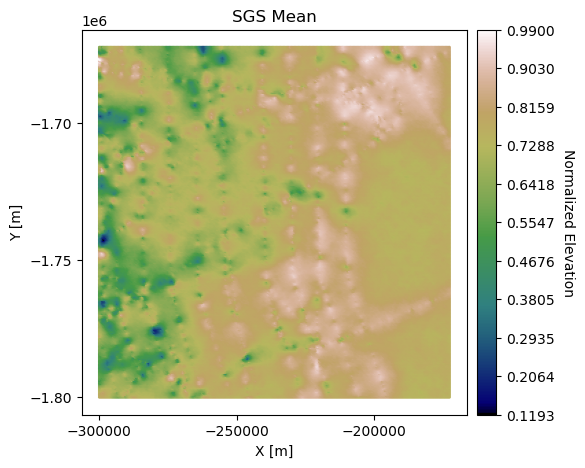

In [7]:
plot_colormap(coord[:,0], coord[:,1], np.mean(sgs, axis = 0), "Normalized Elevation", "SGS Mean")

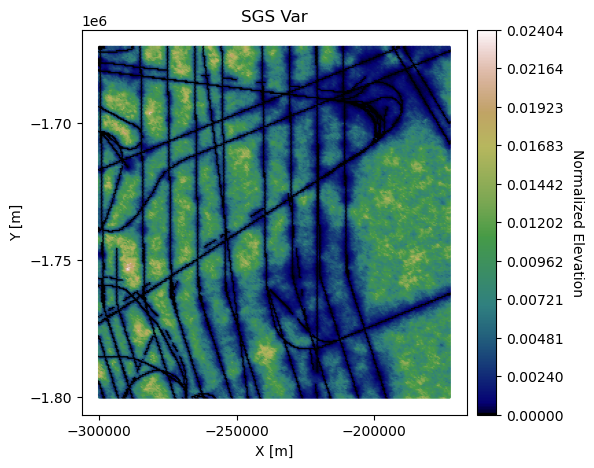

In [8]:
plot_colormap(coord[:,0], coord[:,1], np.var(sgs, axis = 0), "Normalized Elevation", "SGS Var")

In [9]:
# DCGAN - 57 samples
dcgan = np.empty((len(os.listdir(dcgandir)), 256, 256))

for i, name in enumerate(os.listdir(dcgandir)):
        path = os.path.join(dcgandir, name)
        image = Image.open(path).convert('L')
        image_normalized = np.array(image, dtype=np.float32) / 255.0
        
        
        dcgan[i] = image_normalized

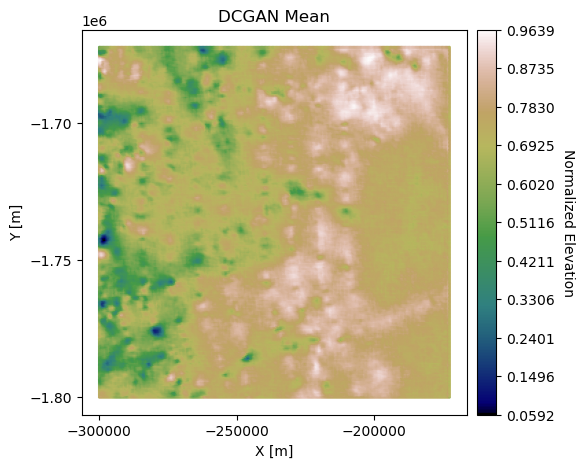

In [10]:
plot_colormap(coord[:,0], coord[:,1], np.mean(dcgan, axis = 0), "Normalized Elevation", "DCGAN Mean")

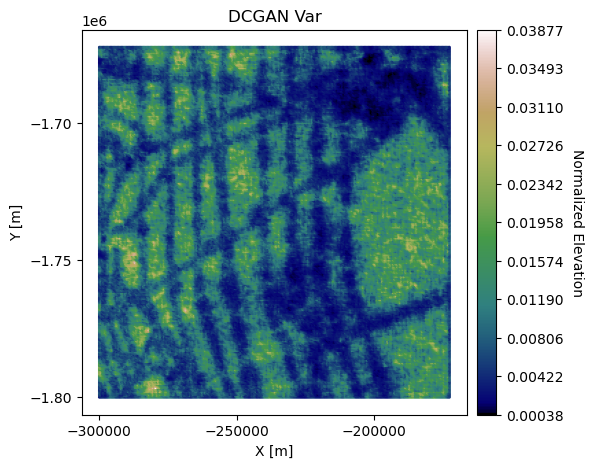

In [11]:
plot_colormap(coord[:,0], coord[:,1], np.var(dcgan, axis = 0), "Normalized Elevation", "DCGAN Var")

In [12]:
# Diffusion - 25 samples

diffusion = pd.read_csv(diffusiondir, header = None)

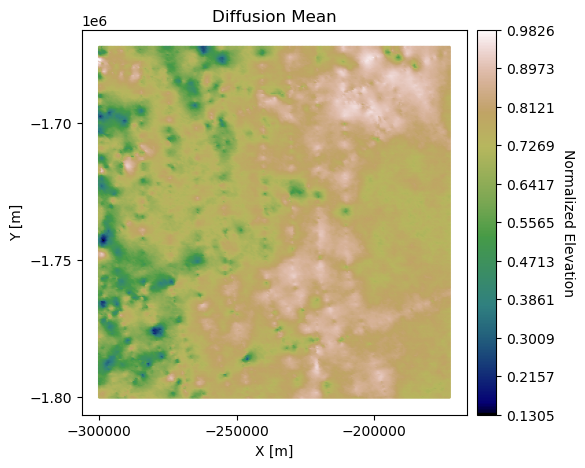

In [13]:
plot_colormap(coord[:,0], coord[:,1], np.mean(diffusion, axis = 0), "Normalized Elevation", "Diffusion Mean")

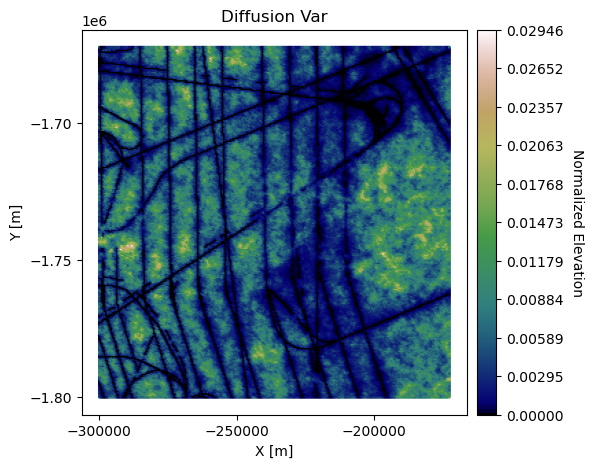

In [14]:
plot_colormap(coord[:,0], coord[:,1], np.var(diffusion, axis = 0), "Normalized Elevation", "Diffusion Var")

In [15]:
# Sampling 5 realizations from each model for variogram calculation

random.seed(0)
sgs_sample_index = random.sample(range(sgs.shape[0]), 5)
dcgan_sample_index = random.sample(range(dcgan.shape[0]), 5)
diffusion_sample_index = random.sample(range(diffusion.shape[0]), 5)

In [16]:
# Plotting and variogram params

maxlag = 50000
n_lags = 30
downsample = 0.1

from itertools import cycle
cycol = cycle('bgrcm')

In [17]:
# SGS variograms

sgs_sample = []

for i in sgs_sample_index:
    vario = skg.Variogram(coord, sgs[i].reshape(256**2), bin_func = 'even', n_lags = n_lags, maxlag = maxlag, normalize = False, samples = downsample)
    sgs_sample.append(vario)

In [18]:
def varioplot(variodata, title):
    fig = plt.figure(figsize=(6,4))
    for data in variodata:
        plt.scatter(data.bins, data.experimental, s=12, c= next(cycol), marker='*')
    plt.title(title)
    #plt.legend(loc="upper left")
    ax = plt.gca()
    ax.set_ylim([0,0.025])
    plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
    fig.savefig('Plots/'+title+'.png', dpi=fig.dpi)

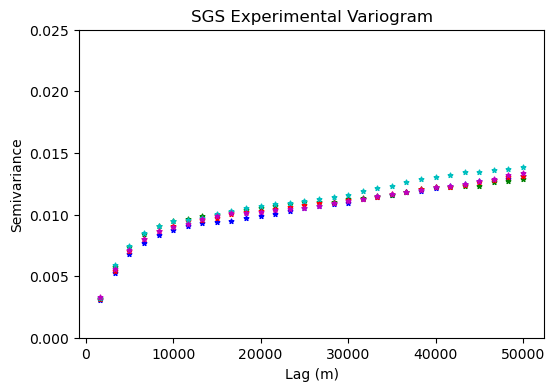

In [19]:
varioplot(sgs_sample, "SGS Experimental Variogram")

In [20]:
#DCGAN variograms

dcgan_sample = []

for i in dcgan_sample_index:
    vario = skg.Variogram(coord, dcgan[i].reshape(256**2), bin_func = 'even', n_lags = n_lags, maxlag = maxlag, normalize = False, samples = downsample)
    dcgan_sample.append(vario)

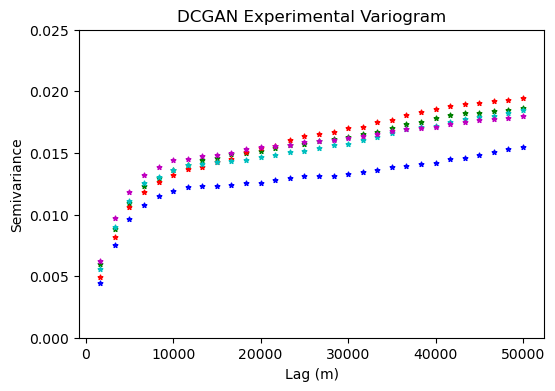

In [21]:
varioplot(dcgan_sample, "DCGAN Experimental Variogram")

In [22]:
# Diffusion Variograms

diffusion_sample = []

for i in diffusion_sample_index:
    vario = skg.Variogram(coord, diffusion.values[i, :], bin_func = 'even', n_lags = n_lags, maxlag = maxlag, normalize = False, samples = downsample)
    diffusion_sample.append(vario)

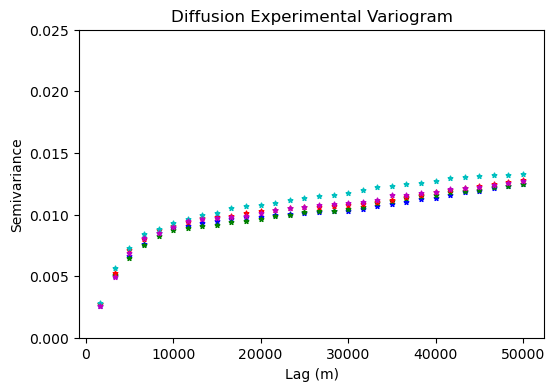

In [23]:
varioplot(diffusion_sample, "Diffusion Experimental Variogram")